In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving celltypes_PBMC.txt to celltypes_PBMC.txt
Saving counts_PBMC.csv to counts_PBMC.csv


# Autoencoder
In this question, we will try to implement **autoencoder(AE)** for dimensionality reduction using `pytorch`. We will test our model on peripheral blood mononuclear cells(PBMCs) single-cell gene expression dataset.

An autoencoder consists of two parts: 

* The encoder network encodes the high dimensional data into low dimensional embedding. 
* The decoder network reconstructs the input high dimensional data from the embedding.


## Read in the data
First, let's read in the PBMCs data that we will use for the training. 

If you're using `colab` please make sure to upload your file(include `celltypes_PBMC.txt` and `counts_PBMC.csv`) first.


In [ ]:
expr_ctrl = pd.read_csv("counts_PBMC.csv", sep = ",", index_col = 0).values
anno_ctrl = pd.read_csv("celltypes_PBMC.txt", sep = "\t", header = None)
expr_ctrl = StandardScaler().fit_transform(expr_ctrl)

# Here we first reduce the dimension with PCA to speed up the training process
expr_ctrl = PCA(n_components = 100).fit_transform(expr_ctrl)
expr_ctrl = torch.FloatTensor(expr_ctrl)


## Create layers
The autoencoder that we use for biological dataset, e.g. single-cell dataset, is built upon multiple fully connected layers(fc layer). So our first step is to create our own fully connected layer from scratch.

**Note**: you may need to use [`nn.Parameter()`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html?highlight=parameter).



In [ ]:
class fc_layer(nn.Module):
    def __init__(self, input_size, output_size, activation = nn.ReLU()):
        """\
          Parameters:
          ----------
          input_size: input dimension of fully connected layers
          output_size: output dimension of fully connected layers
          activation: activation function, default nn.ReLU()
        """
        super(fc_layer, self).__init__()

        # =========================================
        # weight matrix of the fully connected layer, please complete the code here
        # INSERT YOUR CODE BELOW
        # =========================================
        #self.weight = nn.Parameter(torch.FloatTensor(output_size,input_size))
        self.weight = nn.Parameter(torch.zeros(output_size,input_size))
        # =========================================
        # bias of the fully connected layer
        # INSERT YOUR CODE BELOW
        # =========================================
        #self.bias = nn.Parameter(torch.FloatTensor(1,output_size))
        self.bias = nn.Parameter(torch.ones(1,output_size))
        # activation function of the fully connected layer
        self.activation = activation
        # initialize the parameters of weight and bias
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.bias)


    def forward(self, x):
        """\
          x: input data
        """
        # =========================================
        # implement forward pass here (before the activation function)
        # INSERT YOUR CODE BELOW
        # =========================================
        output = x @ self.weight.t() + self.bias
        # call the activation function is there is one, you don't need to revise anything here
        if self.activation is not None:
          output = self.activation(output)
        return output

Next we create all the fc layers in the autoencoder using the `fc_layer` that we have already implemented above.

Layers for the autoencoder will be **number of genes** -> **128** -> **2** --> **128** -> **number of genes**. 


In [ ]:
# The first hidden layer has the input dimension the same as the number of genes in the single-cell dataset,
# the output dimension will be set as 128, relu will be used as the activation function. 
# =========================================
# Please complete the code for hidden_layer1 
# INSERT YOUR CODE BELOW
# =========================================
n_genes = 100
hidden_layer1 = fc_layer(n_genes, 128, activation=nn.ReLU())

# The second hidden layer has the input dimension = 128, and the output dimension = 2. 
# No activation function will be used here.
# =========================================
# Please complete the code for hidden_layer2 
# INSERT YOUR CODE BELOW
# =========================================
hidden_layer2 = fc_layer(128,2,activation = None)

# The third hidden layer has the input dimension = 2, and the output dimension = 128. 
# Relu will be used as the activation function.
# =========================================
# Please complete the code for hidden_layer3
# INSERT YOUR CODE BELOW
# =========================================
hidden_layer3 = fc_layer(2,128,activation=nn.ReLU())

# The output layer has the input dimension = 128, and the output dimension = number of genes. 
# No activation function will be used here.
# =========================================
# Please complete the code for output
# INSERT YOUR CODE BELOW
# =========================================
output = fc_layer(128,n_genes, activation=None)


## Assemble the autoencoder
After creating all the layers, the final step is to assemble the autoencoder with all those layers. `nn.Sequential` would be the most straightforward way fo the implementation. 

Please create your autoencoder using `nn.Sequential`, you might find the link below useful for your implementation:

* https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
* https://stackoverflow.com/questions/46141690/how-to-write-a-pytorch-sequential-model



In [ ]:

# =========================================
# Create the model using nn.Sequential
# INSERT YOUR CODE HERE
# =========================================
autoencoder = nn.Sequential(
    hidden_layer1,
    hidden_layer2,
    hidden_layer3,
    output
)

In [ ]:
# you can print the structure of the model out with print function
print(autoencoder)

Sequential(
  (0): fc_layer(
    (activation): ReLU()
  )
  (1): fc_layer()
  (2): fc_layer(
    (activation): ReLU()
  )
  (3): fc_layer()
)


## Define the optimizer
Gradient descent algorithm will be used to train the parameters of the autoencoder. After creating the autoencoder, we need to define the **optimizer**(can be considered as the gradient descent algorithm) for the model. 

`PyTorch` provides a number of different optimizers for us to choose from, such as `optim.SGD`, `optim.RMSprop`, `optim.Adagrad` and `optim.Adam`. Here we will use stochastic gradient descent(`optim.SGD`) for the optimization. 


In [ ]:
# Learning rate for the optimizer is a key hyperparameter to play around with when we need to train the model.
# Please try with different learning rate and find the one that is suitable for our task.
# =========================================
# INSERT YOUR CODE BELOW
# =========================================
learning_rate = 0.003

optimizer = optim.SGD(autoencoder.parameters(), lr=learning_rate)


## Construct loss function
Loss function is necessary when we want to train a DNN model. We usually use **Mean Square Error(MSE) loss** for autoencoder.

(**Note**: You don't need to implement any code here)

In [ ]:
loss_fcn = nn.MSELoss()

## Train the autoencoder
Here we have arrived at the final step, which is to train the model. We have already implemented this part for you. Make sure to carefully go through the code yourself, as it will help you gain a better understanding of how the model is trained.

In [ ]:
def train_model(model, optimizer, loss_fcn, n_epochs=10):

    batch_size=100
    losses = []

    # we'll train the network for 10 epochs
    step = 0
    for epoch in range(n_epochs):
        # randomize the order of the data each time through
        random_order = np.random.permutation(expr_ctrl.shape[0])
        data_randomized = expr_ctrl[random_order]

        # train the network on batches of size `batch_size`
        for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
            step += 1

            # update the network weights to minimize the loss
            output = model(data_batch)

            # get loss
            loss = loss_fcn(output, data_batch)

            # print the loss every 100 epochs
            if step % 100 == 0:
                print("Step: {} Loss: {:.3f}".format(step, loss.item()))

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()
            losses.append(loss)

    return losses

In [ ]:
losses = train_model(autoencoder, optimizer = optimizer, loss_fcn = loss_fcn, n_epochs = 50)

Step: 100 Loss: 4.673
Step: 200 Loss: 4.060
Step: 300 Loss: 3.106
Step: 400 Loss: 3.955
Step: 500 Loss: 4.563
Step: 600 Loss: 4.052
Step: 700 Loss: 3.627
Step: 800 Loss: 4.325
Step: 900 Loss: 4.163
Step: 1000 Loss: 4.226
Step: 1100 Loss: 3.474
Step: 1200 Loss: 4.646
Step: 1300 Loss: 4.796
Step: 1400 Loss: 3.410
Step: 1500 Loss: 3.579


## Plot the latent embedding
After training the autoencoder, we need to extract the latent embedding that it generates, which correspond to the output of the encoder. 

In [ ]:
# Get the output of the encoder(latent embedding) and visualize it with a scatter plot, complete the code below. Note that it is possible that the result might be different for different runs. 
with torch.no_grad():
    # note that ae_coordinates need to be transformed into numpy for the plot.
    # =========================================
    # INSERT YOUR CODE BELOW
    # =========================================
    ae_coordinates = autoencoder(expr_ctrl).detach().numpy()

AE.pdf


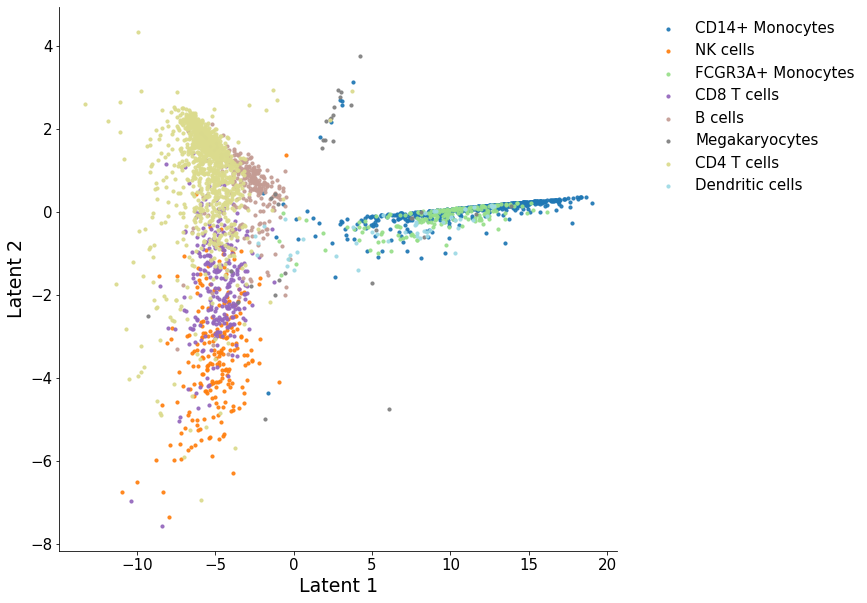

In [ ]:
def plot_latent(z, anno, save = None, figsize = (10,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    cluster_types = set([x for x in np.unique(anno)])
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]
        ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    
    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)



plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "AE.pdf")

## Implement autoencoder using nn.Linear
`Pytorch` actually has wrapped up all the basic layer "Lego" for you, e.g. `nn.Linear` for fully connected layer, `nn.Conv2d` for convolutional layer, etc. 

Please implement the autoencoder we used above using `nn.Linear`, the backbone of the code is already provided as below:

In [ ]:
class autoencoder(nn.Module):
    def __init__(self, in_features):
        super(autoencoder,self).__init__()
        # complete the code for hidden_layer1, hidden_layer2, hidden_layer3, output, 
        # the dimensions of the layers are the same as above 
        # =========================================
        # INSERT YOUR CODE BELOW
        # =========================================
        self.hidden_layer1 = nn.Linear(100,128)
        self.hidden_layer2 = nn.Linear(128,2)
        self.hidden_layer3 = nn.Linear(2,128)
        self.output = nn.Linear(128,100)
        self.encoder = nn.Sequential(
            self.hidden_layer1,
            nn.ReLU(),
            self.hidden_layer2
        )
        self.decoder = nn.Sequential(
            self.hidden_layer3,
            nn.ReLU(),
            self.output
        )
    def forward(self, x):
        # complete the code for forward pass
        # =========================================
        # embed is the output of the encoder
        # INSERT YOUR CODE BELOW
        # =========================================
        embed = self.encoder(x)
        # =========================================
        # output is the output of the decoder
        # INSERT YOUR CODE BELOW
        # =========================================
        output = self.decoder(embed)

        return output 

In [ ]:
ae = autoencoder(in_features = expr_ctrl.shape[1])
optimizer = optim.SGD(ae.parameters(), lr=learning_rate)
losses = train_model(ae, optimizer = optimizer, loss_fcn = loss_fcn, n_epochs = 100)

Step: 100 Loss: 5.031
Step: 200 Loss: 5.036
Step: 300 Loss: 5.319
Step: 400 Loss: 4.468
Step: 500 Loss: 4.914
Step: 600 Loss: 3.927
Step: 700 Loss: 3.985
Step: 800 Loss: 4.424
Step: 900 Loss: 5.691
Step: 1000 Loss: 5.140
Step: 1100 Loss: 3.442
Step: 1200 Loss: 3.878
Step: 1300 Loss: 3.973
Step: 1400 Loss: 5.860
Step: 1500 Loss: 5.928
Step: 1600 Loss: 4.550
Step: 1700 Loss: 3.579
Step: 1800 Loss: 4.357
Step: 1900 Loss: 3.403
Step: 2000 Loss: 4.666
Step: 2100 Loss: 3.685
Step: 2200 Loss: 4.339
Step: 2300 Loss: 3.763
Step: 2400 Loss: 3.404
Step: 2500 Loss: 4.411
Step: 2600 Loss: 4.460
Step: 2700 Loss: 4.622
Step: 2800 Loss: 3.575
Step: 2900 Loss: 3.881
Step: 3000 Loss: 3.645


AE2.pdf


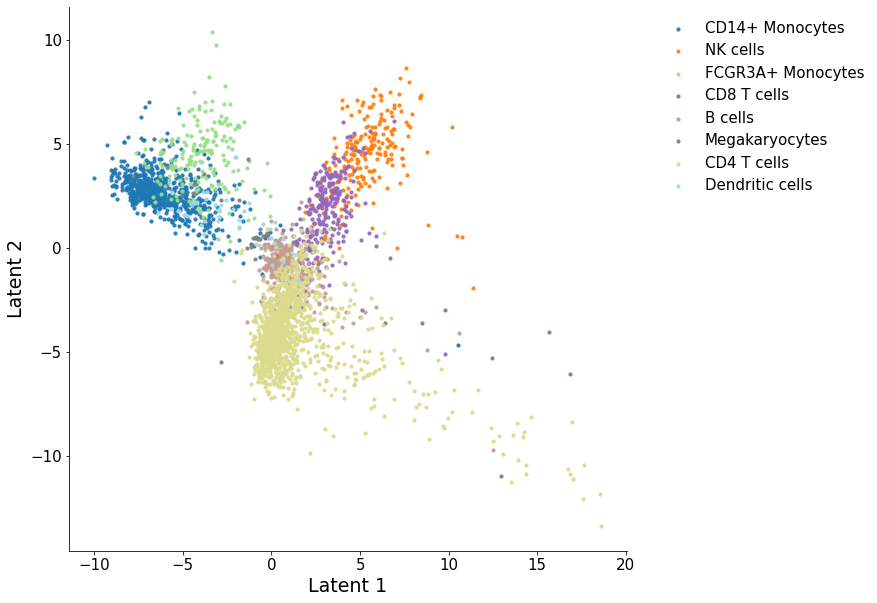

In [ ]:
# Get the output of the encoder(latent embedding) and visualize it with a scatter plot, complete the code below. Note that plot that you get might not be the same as the first plot, and it's also possible that the result is different for different runs.
with torch.no_grad():
    # note that ae_coordinates need to be transformed into numpy for the plot.
    # =========================================
    # INSERT YOUR CODE BELOW
    # =========================================
    ae_coordinates = ae.encoder(expr_ctrl).detach().numpy()

plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "AE2.pdf")